<a href="https://colab.research.google.com/github/costayca/GroceryCNN/blob/main/GroceryCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#import required libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [4]:
#import model

## Resnet
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

## NasNetLarge
#from tensorflow.keras.applications.nasnet import NASNetLarge
#from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions

## NasNetMobile
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions


In [82]:
%cd /content/drive/MyDrive/Licenta/23.11.2020/

/content/drive/MyDrive/Licenta/23.11.2020


In [83]:
#image data generator

# Image data Generator parameters
#                                     width_shift_range=[-100,100],
#                                    height_shift_range=[-100,100],
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    rotation_range=90,
#                                    brightness_range=[0.6,1.0],
#                                    zoom_range=[0.9,1.0]
train_datagen = ImageDataGenerator(
                                   preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory("dataset/train",
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=16,
                                                    class_mode="categorical")

Found 3704 images belonging to 37 classes.


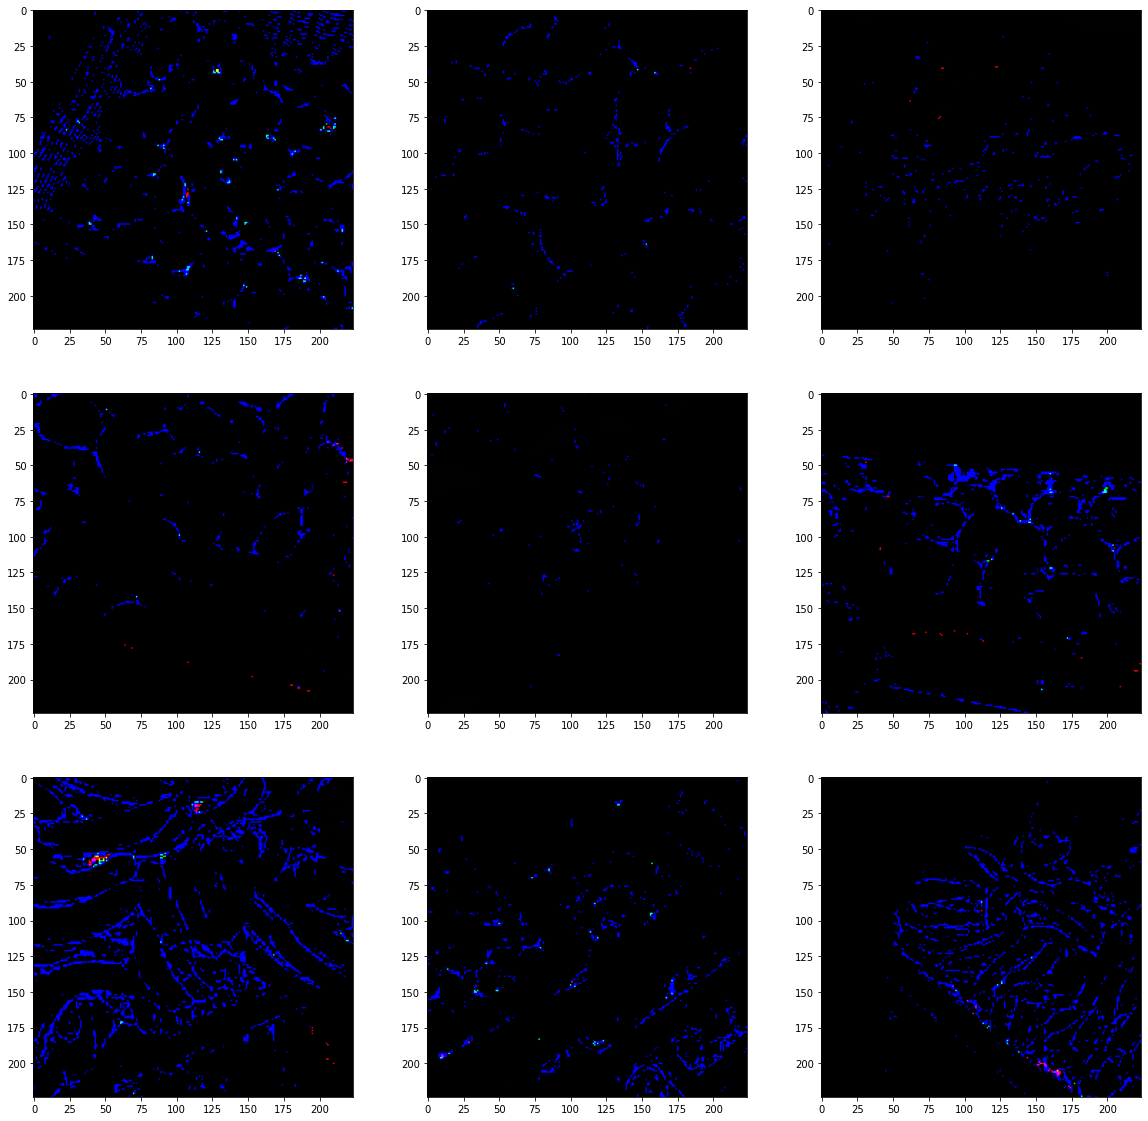

In [63]:
# image generator test

from matplotlib import pyplot

pyplot.figure(figsize=(20, 20))

# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = train_generator.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image.squeeze())
 
 # show the figure
pyplot.show()

In [84]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_generator = valid_datagen.flow_from_directory("dataset/val",
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=16,
                                                    class_mode="categorical")

Found 1066 images belonging to 37 classes.


## Transfer Learning

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [85]:
base_model = NASNetMobile(include_top=False, input_shape=(224,224,3))

In [86]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [87]:
model_tl = Sequential()

model_tl.add(base_model)
model_tl.add(Flatten())
model_tl.add(Dense(37, activation="softmax"))

In [88]:
model_tl.layers[0].trainable = False

In [89]:
model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
flatten_1 (Flatten)          (None, 51744)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)                1914565   
Total params: 6,184,281
Trainable params: 1,914,565
Non-trainable params: 4,269,716
_________________________________________________________________


In [90]:
# compiling
model_tl.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [91]:
# Create a checkpoint
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = "/content/drive/MyDrive/Licenta/23.11.2020/checkpoints/save_model.hdf5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                            monitor="accuracy", 
                                            save_best_only=True, 
                                            verbose=1,
                                            mode='auto',
                                            save_freq='epoch')

In [92]:
fit_history = model_tl.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[model_checkpoint_callback])

Epoch 1/5
232/232 [==============================] - 2377s 10s/step - loss: 5.0412 - accuracy: 0.5786 - val_loss: 2.7927 - val_accuracy: 0.8030

Epoch 00001: accuracy improved from -inf to 0.70059, saving model to /content/drive/MyDrive/Licenta/23.11.2020/checkpoints/save_model.hdf5
Epoch 2/5
232/232 [==============================] - 534s 2s/step - loss: 0.8427 - accuracy: 0.9153 - val_loss: 2.4765 - val_accuracy: 0.8218

Epoch 00002: accuracy improved from 0.70059 to 0.91631, saving model to /content/drive/MyDrive/Licenta/23.11.2020/checkpoints/save_model.hdf5
Epoch 3/5
232/232 [==============================] - 537s 2s/step - loss: 0.3792 - accuracy: 0.9613 - val_loss: 3.0443 - val_accuracy: 0.8114

Epoch 00003: accuracy improved from 0.91631 to 0.95896, saving model to /content/drive/MyDrive/Licenta/23.11.2020/checkpoints/save_model.hdf5
Epoch 4/5
232/232 [==============================] - 536s 2s/step - loss: 0.3363 - accuracy: 0.9666 - val_loss: 3.4121 - val_accuracy: 0.8358

Epo

In [93]:
model_tl.load_weights(checkpoint_filepath)

## Test the model

In [94]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory("dataset/test",
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=16,
                                                    class_mode="categorical",
                                                    shuffle=False)

Found 296 images belonging to 37 classes.


### Visualize predictions

In [95]:
test_generator.reset()

pred = model_tl.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


19/19 [==============================] - 147s 8s/step


In [96]:
predicted_class_indices = np.argmax(pred, axis = 1)

In [19]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

In [105]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(224, 224)))

def plot_image(base_path, images, image_count, labels, image_width=18, image_height=12):
    fig=plt.figure(figsize=(image_width, image_height))
    
    columns = 10
    rows = image_count // columns

    for i in range(1, columns*rows + 1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(labels[i])
        img = read(os.path.join(base_path, images[i]))
        plt.imshow(img, interpolation='nearest')

In [97]:
labelList = os.listdir("dataset/train")

labelList.sort()

print(predicted_class_indices)
print(len(predicted_class_indices))
print(labelList)

labels = [labelList[i] for i in predicted_class_indices]

[ 0  0  0  0  0 11  0  0 11  0  0  0 34  0  0 34  0  0  0 24  0  0  1  1
  1  7  7 16  2  2  2  3  3  3  3  3  4  4  4  4  4  7  5 28  5  5 28  6
  6  6  6  6  7  7  7  7  7  8  8  8  8  8 28 28 28 28 10 10 10 10 10 10
 10 10 35 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11
 16 11 11 11 12 12 12 12 16 31 31 16 16 14 14 14 14 14 24 22 22 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 10 18 35 10 19
 35 19 19 19 19 20 16 20 28  2 21 21 16 21 21  3 22  3 22 22 16 23 24 23
 23 24 24 24 28 34 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 20 26 12
  1 26 27 27 27 27 27 16 28 11 11  0 28 28 28 28  7 29 29 29 22 29 31 16
 31 21  0 11  0 31  0  0 32 32 35 32 32 33 33 33 33 33 10 33 33 17 35 34
 34 34 34 34 34 34 34 10 17 35 17 35 35 35 35 35 35 35 35 10 35 16 35 35
 35 10 35 36 36 36 36 36]
296
['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Brown-Cap-Mushroom', 'Cabbage', 'Car

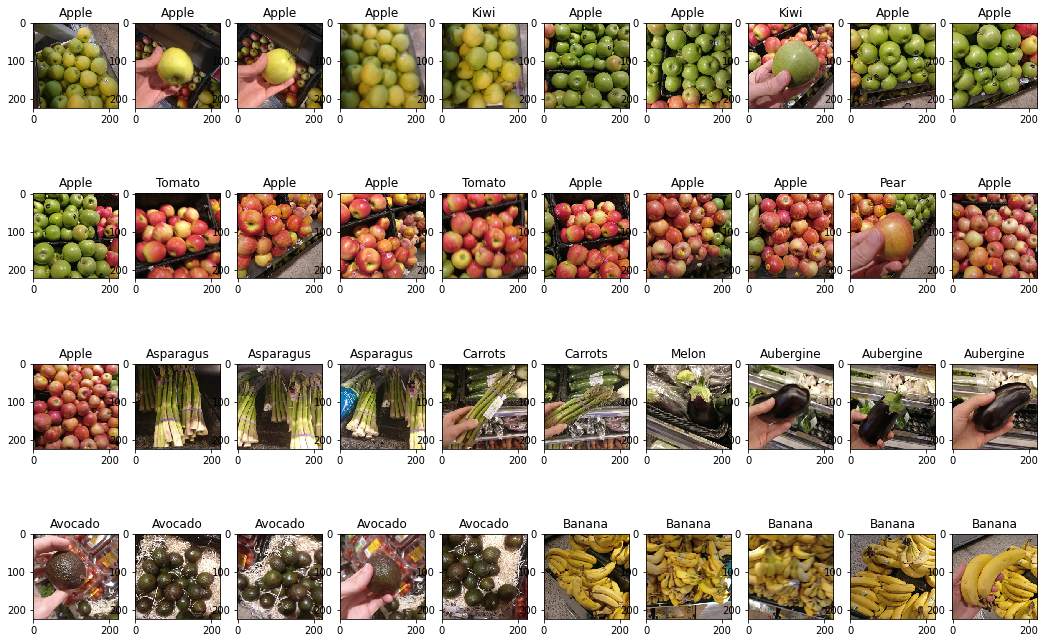

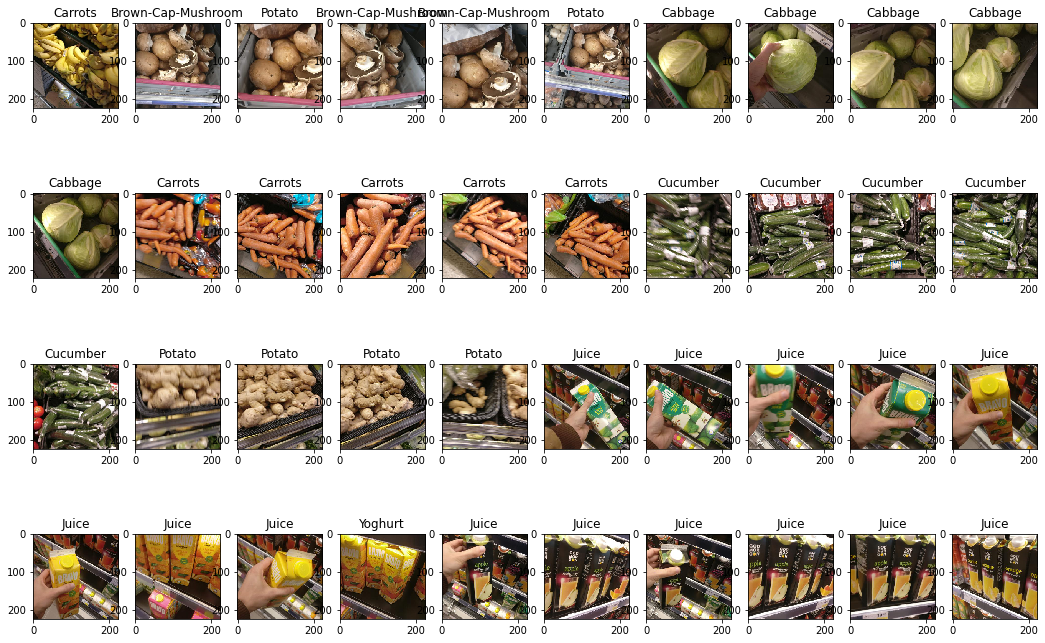

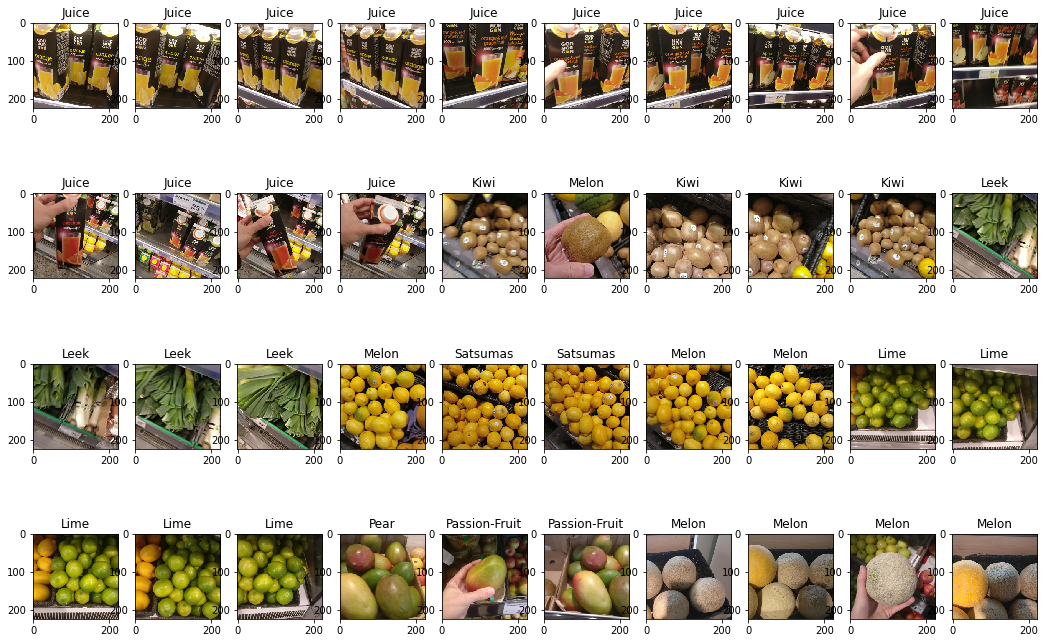

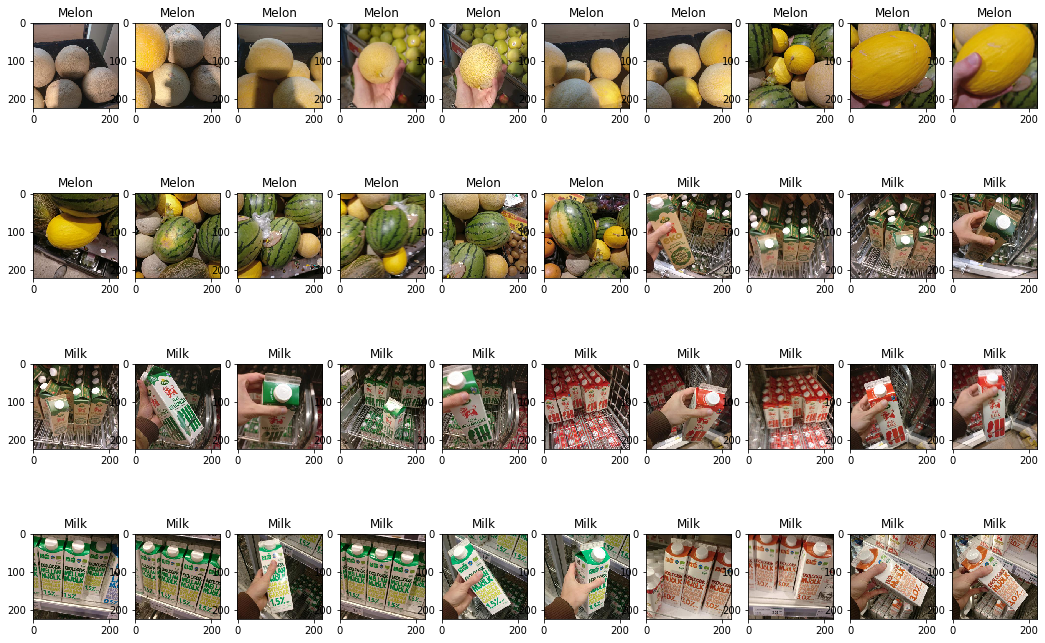

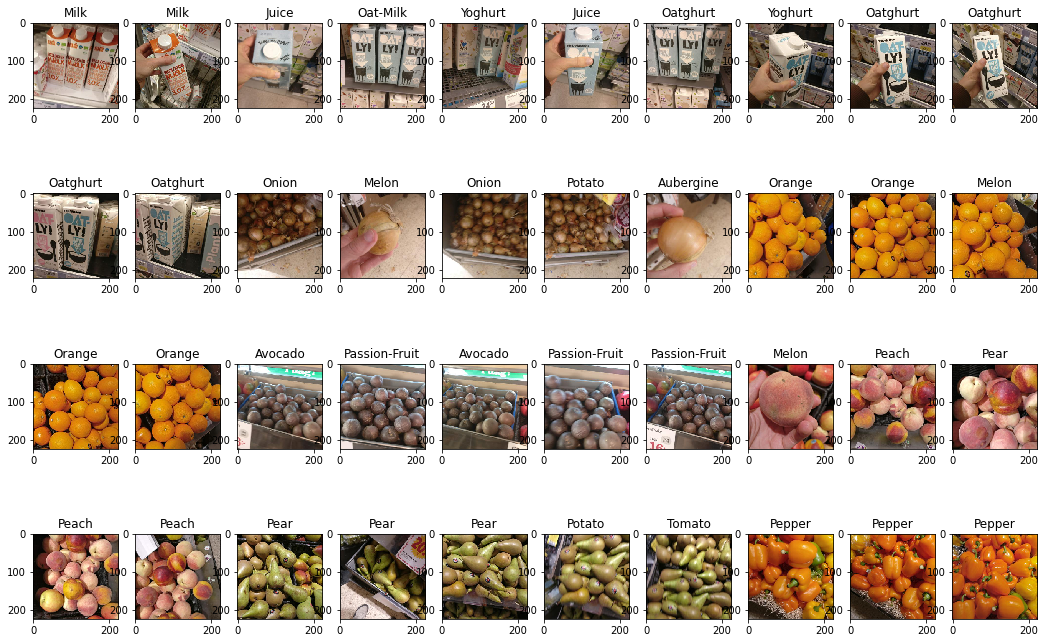

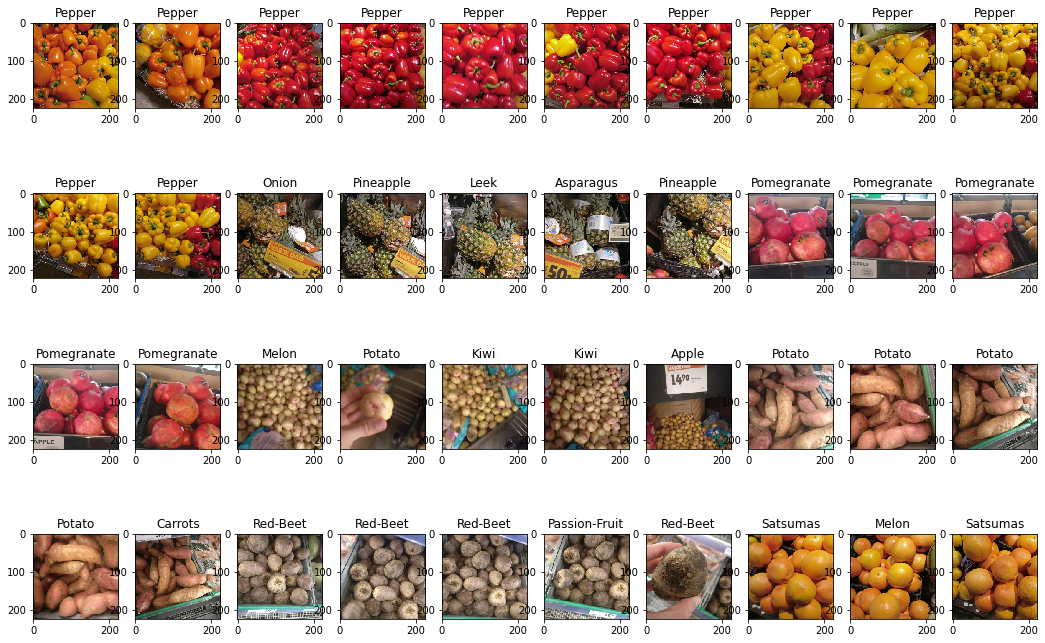

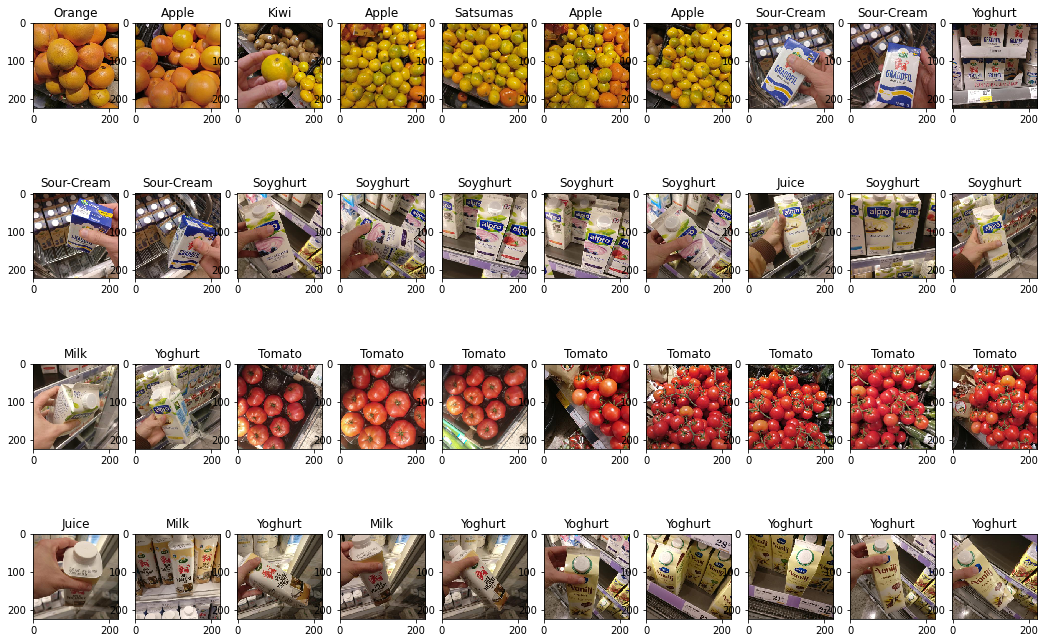

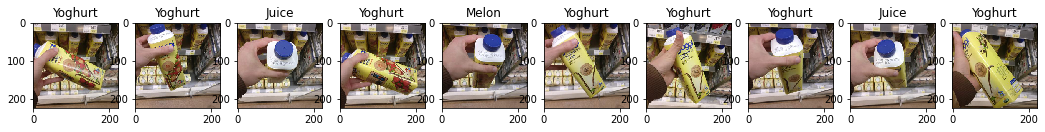

In [108]:
plot_image("dataset/test", test_generator.filenames, 40, labels)
plot_image("dataset/test", test_generator.filenames[40:], 40, labels[40:])
plot_image("dataset/test", test_generator.filenames[80:], 40, labels[80:])
plot_image("dataset/test", test_generator.filenames[120:], 40, labels[120:])
plot_image("dataset/test", test_generator.filenames[160:], 40, labels[160:])
plot_image("dataset/test", test_generator.filenames[200:], 40, labels[200:])
plot_image("dataset/test", test_generator.filenames[240:], 40, labels[240:])
plot_image("dataset/test", test_generator.filenames[280:], 16, labels[280:])